## Global Macro Dashboard

An overview of some important indicators of the global economy's health.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import quandl

import pandas_datareader.data as web
import xlrd as xls
import datetime
import missingno as msno

import os
import sys
import shutil
from pathlib import Path

from IPython.core.display import HTML

%matplotlib inline
plt.close('all')
plt.style.use('seaborn-bright')
plt.rcParams['lines.linewidth'] = 1.5

import nbconvert
#html_css_files = ['https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css']

from passwords import quandl_token

In [3]:
# Setting dates for plotting
# set now to current time and date
now = datetime.datetime.now()
# set a start date in the past
start = datetime.datetime(2008, 1, 1)
# other start/end options: 
# start = '20080101'
# end = ''
today = datetime.datetime(now.year, now.month, now.day)

**Refactor code:**
- after library import have one section for raw data download; save raw data as CSVs
- add try/except in case download / API fails - have fallback to old CSV 
- next section: clean raw data, then save cleaned data as CSVs
- use cleaned CSV files to do analysis, plot etc

## Growth and Liquidity

### 1. Growth

#### GDP now

### 2. Liquidity drivers

### 3. Inflation

### 10y breakevens and 5y5y forward

In [4]:
# load from FRED API & save copy locally to CSV file
try:
    US_infl_exp_download = web.DataReader(['T10YIE','T5YIFR'], 'fred')
    US_infl_exp_download.to_csv('data/US_infl_exp.csv')
    
except Exception as e:
    print(e)

/Users/marceldietsch/ml/env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


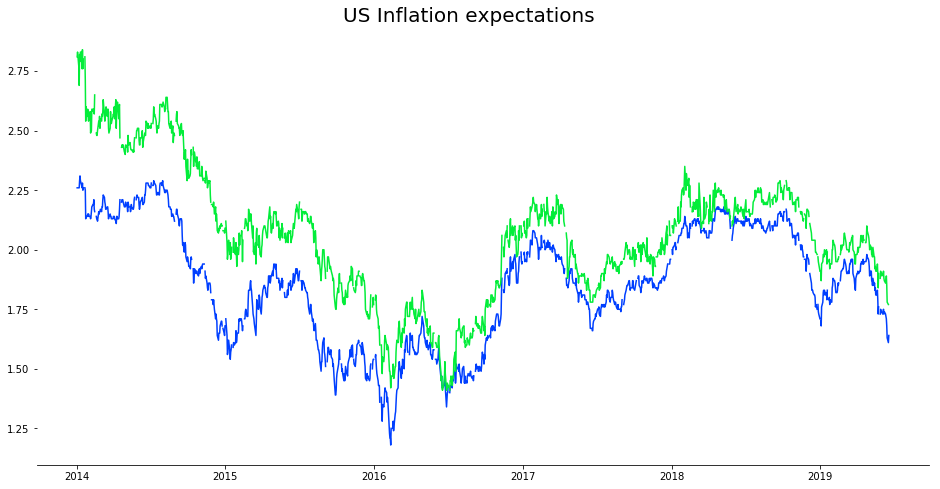

In [5]:
start = '20140101'

figure_data = US_infl_exp_download.loc[start:]
plt.figure(figsize=(16, 8))
plt.suptitle("US Inflation expectations", fontsize=20, y=.92)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

### US Treasury bond yields

#### Load data US treasury bond yields

In [6]:
# load from Quandl API & save copy locally to CSV file
try:
    UST_download = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
    UST_download.to_csv("data/US_treasury_yields.csv")

except Exception as e:
    print(e)

In [7]:
# load CSV into pandas DF and replace index column with date column
US_treasury_yields = pd.read_csv("data/US_treasury_yields.csv", parse_dates=['Date'])
US_treasury_yields.set_index(['Date'], drop=True, inplace=True)

#### Load US data on GDP, inflation etc from FRED

In [8]:
US_GDP = web.DataReader('GDP', 'fred')
US_GDP.to_csv("data/US_GDP.csv")
US_inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred')
US_inflation.to_csv("data/US_inflation.csv")

# FRED also has Treasury yield data available, but there seem to be more missing
# values compared to quandl, so using Quandl as above
# UST_3m_FRED = web.DataReader(['T10Y3MM'], 'fred', start, end)
# UST_2y_FRED = web.DataReader(['T10Y2Y'], 'fred', start, end)

#### VIX

In [9]:
VIX_raw = web.DataReader('VIXCLS', 'fred')
VIX_raw.to_csv("data/VIX.csv")

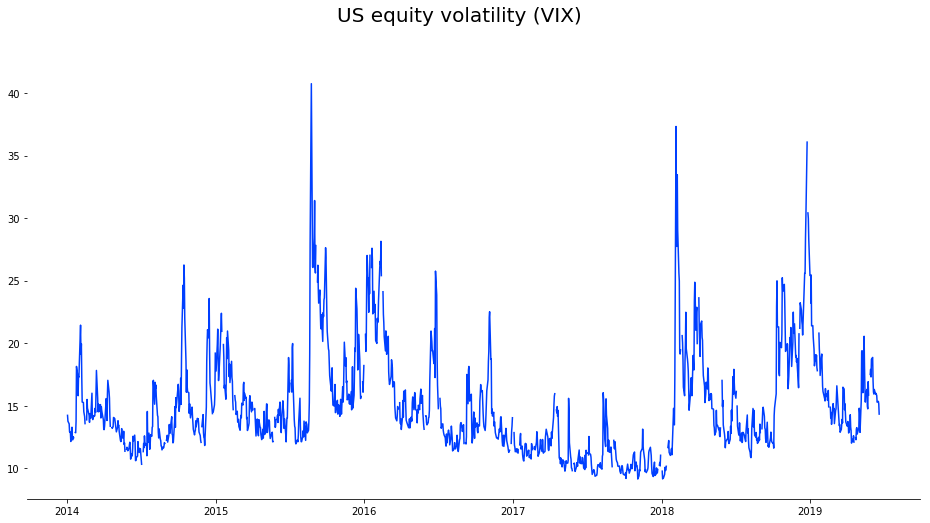

In [10]:
start = '20140101'

figure_data = VIX_raw.loc[start:]
plt.figure(figsize=(16, 8))
plt.suptitle("US equity volatility (VIX)", fontsize=20)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

#### Load data for copper / gold ratio from Quandl

In [11]:
# load from Quandl API & save copy locally to CSV file
try:
    copper_download = quandl.get("CHRIS/CME_HG2", authtoken=quandl_token)
    gold_download = quandl.get("CHRIS/CME_GC2", authtoken=quandl_token)
    copper_download.to_csv("data/copper_2nd.csv")
    gold_download.to_csv("data/gold_2nd.csv")

except Exception as e:
    print(e)

In [12]:
# load CSV into pandas DF
copper_2nd_cont = pd.read_csv("data/copper_2nd.csv", parse_dates=['Date'])
gold_2nd_cont = pd.read_csv("data/gold_2nd.csv", parse_dates=['Date'])
# replace index column with datetime
copper_2nd_cont.set_index(['Date'], drop=True, inplace=True)
gold_2nd_cont.set_index(['Date'], drop=True, inplace=True)

In [13]:
copper_settle = copper_2nd_cont["Settle"]
copper_settle.tail()

Date
2019-06-13    2.6565
2019-06-14    2.6295
2019-06-17    2.6465
2019-06-18    2.7030
2019-06-19    2.6805
Name: Settle, dtype: float64

In [14]:
gold_settle = gold_2nd_cont["Settle"]
gold_settle.tail()

Date
2019-06-13    1343.7
2019-06-14    1344.5
2019-06-17    1342.9
2019-06-18    1350.7
2019-06-19    1348.8
Name: Settle, dtype: float64

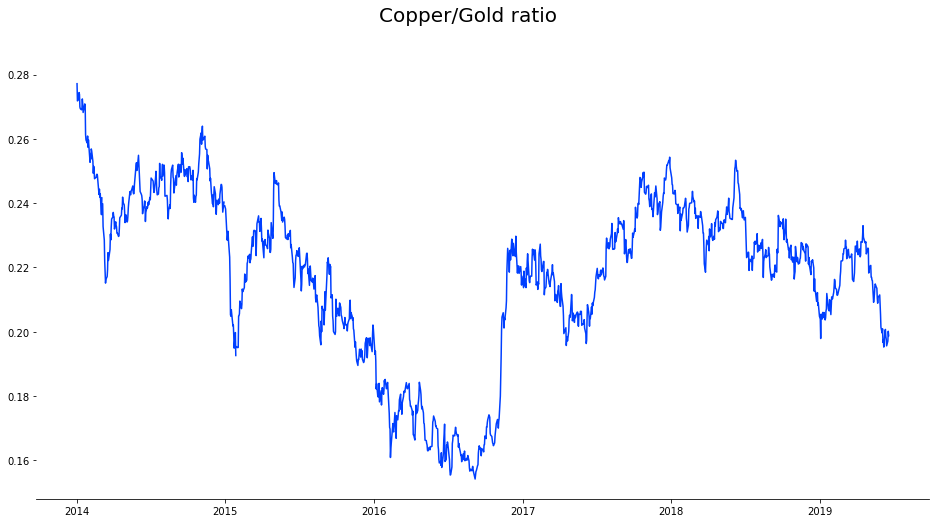

In [15]:
# set date range (specific to this ratio)
start_cu_au = datetime.datetime(2014, 1, 1)

copper_gold = pd.concat([copper_settle, gold_settle], axis=1)
column_rename = copper_gold.columns.values
column_rename[0] = 'Copper'
column_rename[1] = 'Gold'
copper_gold.columns = column_rename
cu_au_ratio = (copper_gold["Copper"] * 100 / copper_gold["Gold"])

figure_data = cu_au_ratio.loc[start_cu_au:]
plt.figure(figsize=(16, 8))
plt.suptitle("Copper/Gold ratio", fontsize=20, y=.98)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

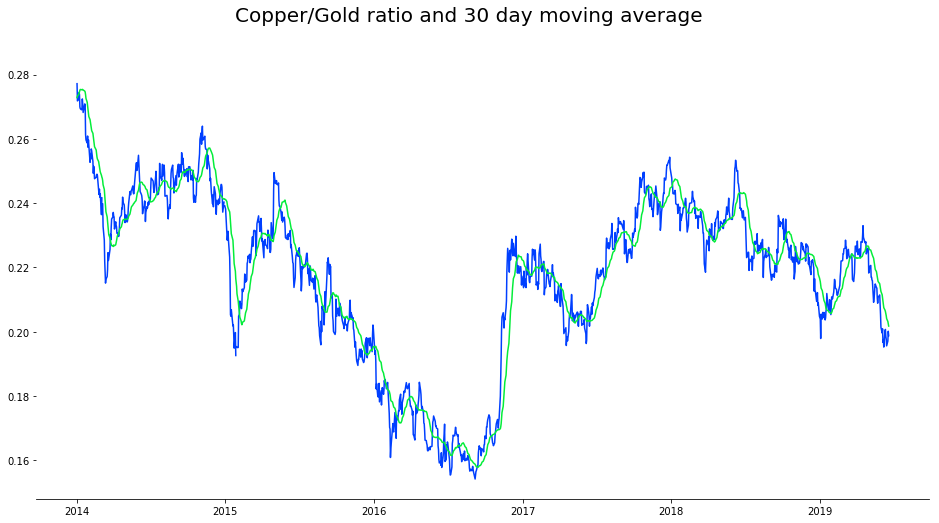

In [16]:
copper_gold['ratio'] = copper_gold['Copper'] * 100 / copper_gold['Gold']
copper_gold['30d_ma'] = copper_gold['ratio'].rolling(window=20, min_periods=0).mean()
figure_data = copper_gold[['ratio', '30d_ma']].loc[start_cu_au:]
plt.figure(figsize=(16, 8))
plt.suptitle("Copper/Gold ratio and 30 day moving average", fontsize=20)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

### GDP nowcasts

#### Atlanta data download 
check if tracking QoQ or YoY

In [17]:
# St Louis Fred nowcast
# https://fred.stlouisfed.org/series/STLENI
# US_GDP_nowcast = web.DataReader('STLENI', 'fred')

# https://www.newyorkfed.org/research/policy/nowcast
# https://fred.stlouisfed.org/series/STLENI
# Quandl nowcasts?

#### Full data

In [18]:
# right file? Check Fred
Atlanta_GDP_now_dl = pd.read_excel("https://www.frbatlanta.org/-/media/documents/cqer/researchcq/gdpnow/GDPTrackingModelDataAndForecasts.xlsx")

In [19]:
Atlanta_GDP_now_dl.tail()

,6703 11902,.excel_last,FRBCNAI@SURVEYS,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Correlation of Factors,Unnamed: 10,Unnamed: 11,0.9765259020493547
627,1812,2018-12-31,-0.01,-0.077024,2018-12-01,-0.01,-0.077024,0,NaN,NaN,NaN,NaN,NaN
628,1901,2019-01-31,-0.25,-0.200143,2019-01-01,-0.25,-0.200143,0,NaN,NaN,NaN,NaN,NaN
629,1902,2019-02-28,-0.29,-0.525946,2019-02-01,-0.29,-0.525946,0,NaN,NaN,NaN,NaN,NaN
630,NaN,2019-03-31,NaN,NaN,2019-03-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
631,NaN,NaT,NaN,NaN,2019-04-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


#### NY Fed GDP 
tracks the annualized quarterly (“q/q”) growth rate of real GDP,not the four-quarter (“y/y”) growth rat

In [20]:
# check sources
# https://github.com/FRBNY-TimeSeriesAnalysis/Nowcasting
  
# The newestreleases for all data series are publicly available from source websites;
# real-time historical data for most series can be retrieved from the St. LouisFed’s ALFRED database.

# FRED!

In [21]:
US_treasury_yields.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2019-06-13,2.24,2.23,2.19,2.18,2.00,1.83,1.78,1.84,1.96,2.10,2.39,2.61
2019-06-14,2.23,2.21,2.20,2.18,2.00,1.84,1.79,1.85,1.96,2.09,2.38,2.59
2019-06-17,2.22,2.21,2.23,2.20,2.03,1.86,1.80,1.85,1.96,2.09,2.37,2.58
2019-06-18,2.18,2.20,2.22,2.20,2.04,1.86,1.80,1.83,1.93,2.06,2.34,2.55
2019-06-19,2.14,2.18,2.18,2.11,1.96,1.74,1.70,1.77,1.89,2.03,2.32,2.54


#### Visualising US Treasury yields for different tenors 

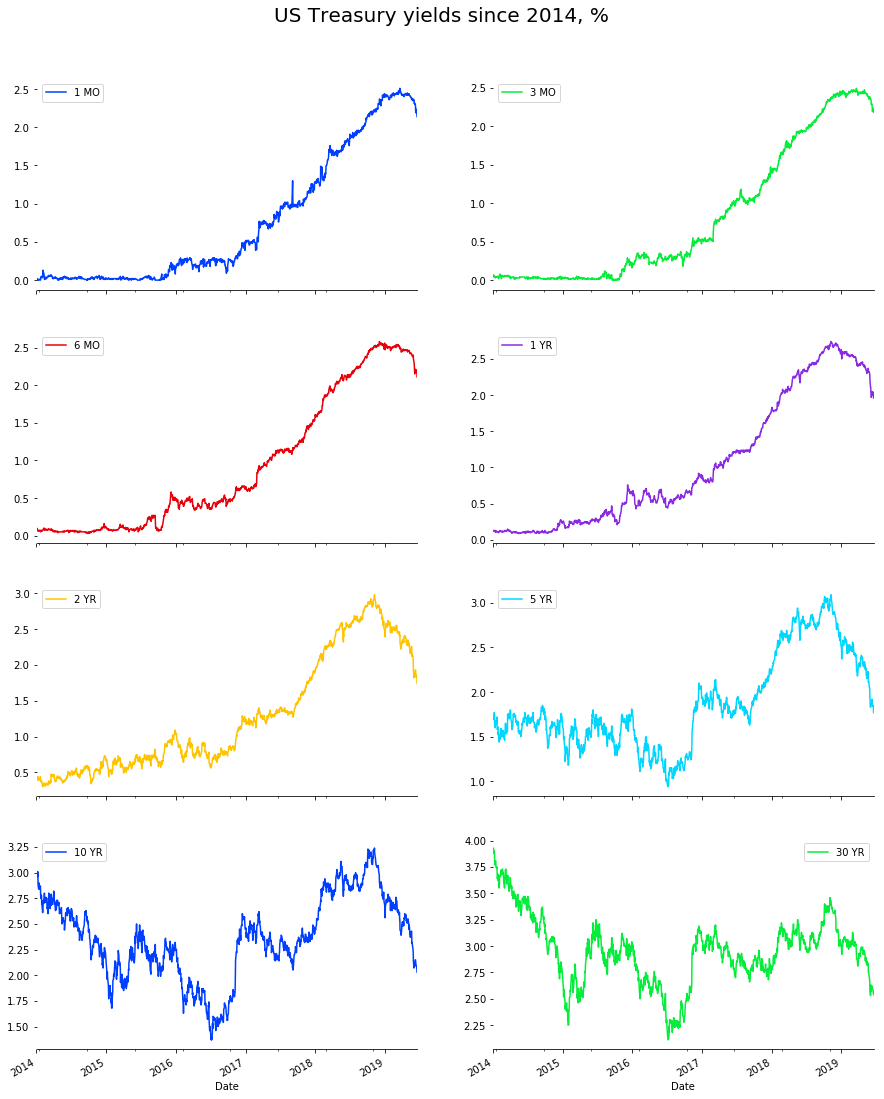

In [22]:
start = '20140101'

select_columns = ["1 MO", "3 MO", '6 MO', '1 YR', '2 YR', '5 YR','10 YR', '30 YR']
US_treasury_yields_subplot = US_treasury_yields[select_columns]

US_treasury_yields_subplot.loc[start:].plot(subplots=True, layout=(5,2), figsize=(15, 25))
sns.despine(left=True, bottom=False, right=True)
plt.suptitle("US Treasury yields since 2014, %", fontsize=20, y=0.92)
plt.show();


/Users/marceldietsch/ml/env/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/marceldietsch/ml/env/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


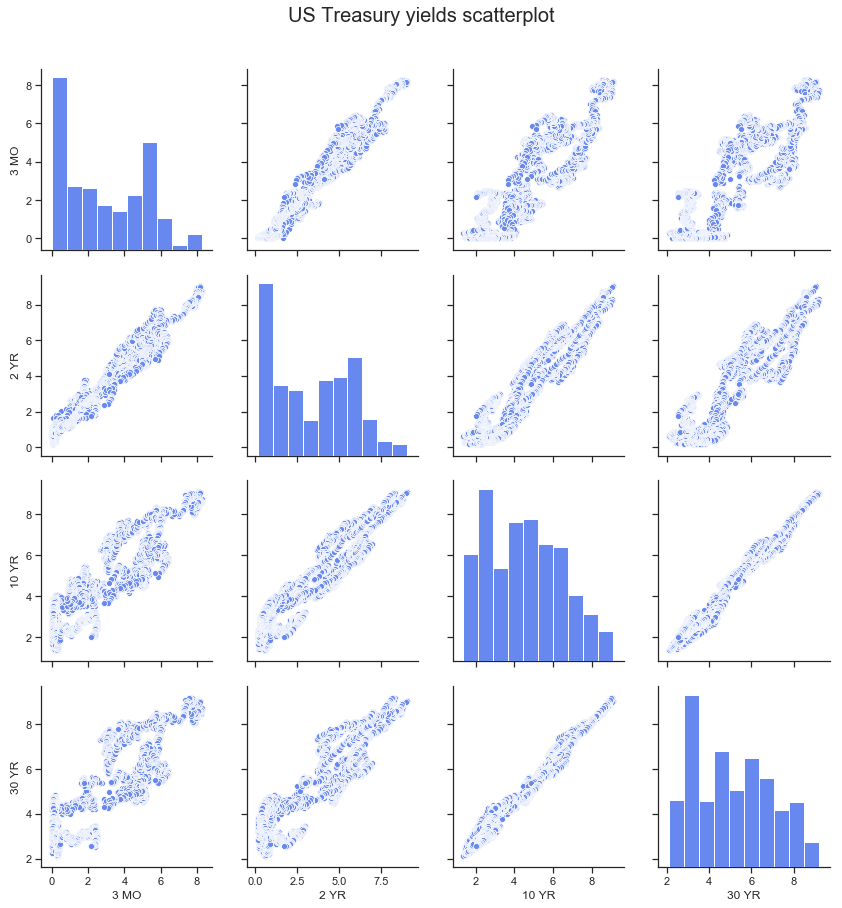

In [95]:
sns.set_palette("coolwarm")
sns.pairplot(US_treasury_yields[['3 MO', '2 YR','10 YR', '30 YR']],height=3)
plt.suptitle("US Treasury yields scatterplot", fontsize=20, y=1.05)
plt.show()

#### US Treasury yield curves 

In [23]:
TSY3m2y =  US_treasury_yields['2 YR'] - US_treasury_yields['3 MO']
TSY2y10y = US_treasury_yields['10 YR'] - US_treasury_yields['2 YR']

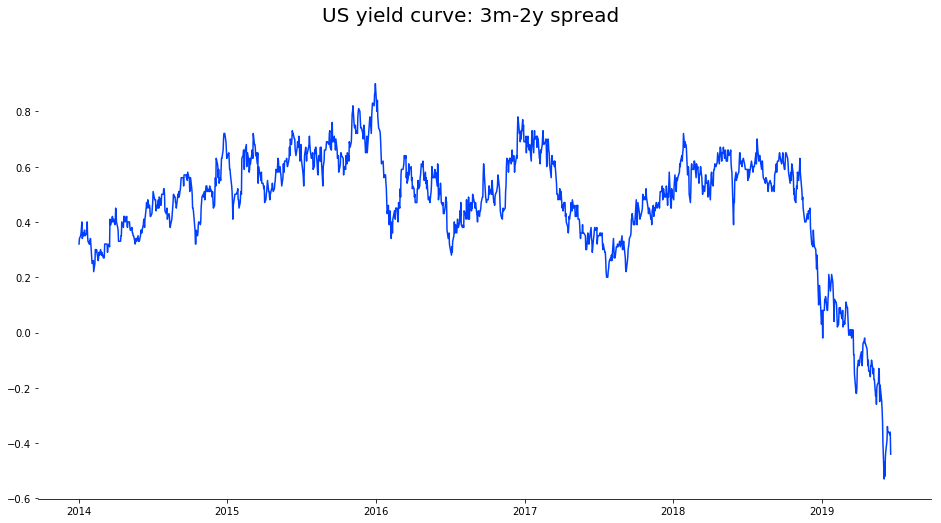

In [24]:
figure_data = TSY3m2y.loc[start:]
plt.figure(figsize=(16, 8))
plt.suptitle("US yield curve: 3m-2y spread", fontsize=20)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

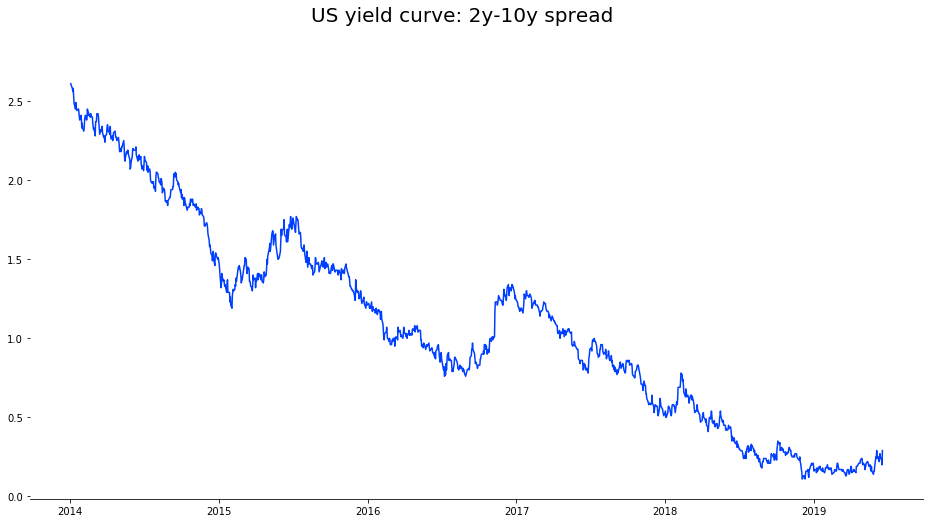

In [25]:
figure_data = TSY2y10y.loc[start:]
plt.figure(figsize=(16, 8))
plt.suptitle("US yield curve: 2y-10y spread", fontsize=20)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

#### Plot US yield curve - today v 3m ago

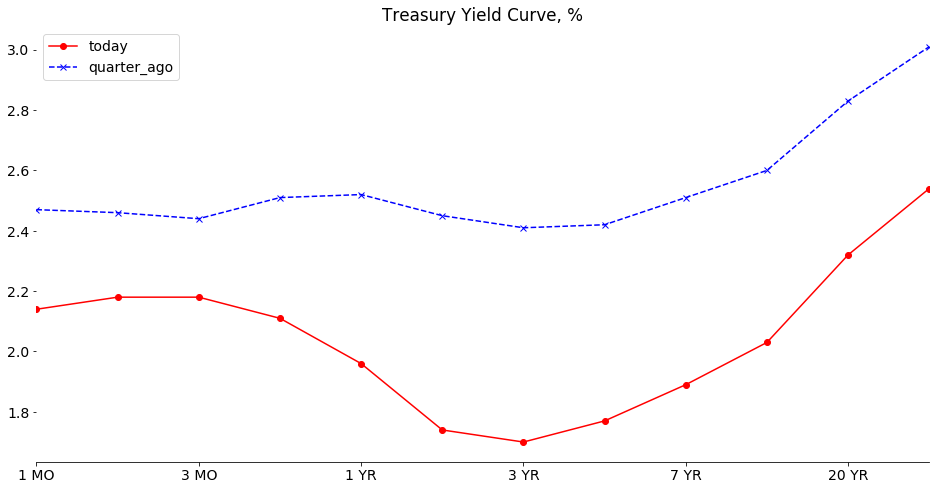

In [26]:
# WRITE PLOTTING FUNCTION SO IT CAN BE RE-USED
# + ANIMATED VERSION?
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)


US_today = US_treasury_yields.iloc[-1,:]
US_quarter_ago = US_treasury_yields.iloc[-66,:]
df = pd.concat([US_today, US_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']



df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='Treasury Yield Curve, %', figsize=(16, 8))
sns.despine(left=True, bottom=False, right=True)



## German bond yields and curves

### Data sources

#### Create list of bond tenors

In [27]:
tenor = ['6 MO', '1 YR', '2 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']

#### Import data from Bundesbank website

In [28]:
# creates dictionary where keys represent bond tenors and values are the URL of corresponding dataset

base_url = "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId="

DE = {"DE6 MO_input": base_url + "BBK01.WT3210",
      "DE1 YR_input": base_url + "BBK01.WT3211",
      "DE2 YR_input": base_url + "BBK01.WT3213",
      "DE5 YR_input": base_url + "BBK01.WT3219",
      "DE7 YR_input": base_url + "BBK01.WT3223",
      "DE10 YR_input": base_url + "BBK01.WT3229",
      "DE20 YR_input": base_url + "BBK01.WT3449",
      "DE30 YR_input": base_url + "BBK01.WT3500"}

### Functions for loading, cleaning and concatenating data

In [29]:
def instrument_names(tenors):
    """
    creates variable names for each instrument, e.g. "DE2y" for a
    2yr German bond and also input variables that will be used in
    subsequent cleaning functions, e.g. DE2y_input
    """
    input_names = [0] * len(tenors)
    
    for i in tenors:
        index = tenors.index(i)
        if index < len(tenors):
            tenors[index] = 'DE'+ i
            input_names[index] = tenors[index] + '_input'
            
    return tenors, input_names

def bunds_clean(URL, tenor):
    """
    Loads and transforms very poorly formatted CSV files with data for each
    bond tenor from German Bundesbank and returns cleaned pandas dataframe
    """
    
    # Use pandas read_csv to download file, if that fails use wget
    try:
        DF = pd.read_csv(URL, sep=';')
    except Exception as e:
        print("Problem with file download via Pandas read_csv")
        print(e)
        print("=================================================")
        print("Trying with wget instead - will create separate CSV files")
        filenumber = tenor[0] + 'a'
        filename = 'bund' + filenumber +'.csv'
        !wget {URL} -O "data/{filename}" -q
        PATH = "data/" + filename
        DF = pd.read_csv(PATH, sep=';')

    assert type(tenor) == str, "Tenor needs to be a string"   
    
    # remove rows without relevant data
    # the first four rows of all files need to be removed the last row 
    # needs to be removed in some files: - tenors 20 YR + 30 YR are fine
    # hence DF[4:] below, but tenors up to 10 YR contain a comment in
    # the last row, which needs to be removed, hence DF[4:-1] for all of those
    
    last_row = DF[-1:].to_string()
    if "Bemerkung" in last_row:
        DF = DF[4:-1]
    else:
        DF = DF[4:]  
        
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
    DF.columns = new_columns 
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    
    # use dropcolumn to remove rows that have missing values (indicated by
    # string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)
    
    # reset dataframe index to 0 - was not the case because removed rows earlier
    DF.reset_index(drop=True, inplace=True)
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
    
    # convert RATE column values from string to float
    DF[tenor] = DF[tenor].astype('float')
    
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])
    
    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

def clean_and_join(input_name, tenor):
    """
    Calls bunds_clean function for each input file and concatenates 
    cleaned output into one pandas dataframe, which is returned
    """
    combined = pd.DataFrame() 
    
    for i in range(len(tenor)):
        result = bunds_clean(DE[input_name[i]], tenor[i])
        combined = pd.concat([combined, result], axis=1)
        
    return combined

In [30]:
results = instrument_names(tenor[:])
instruments = results[0]
input_name = results[1]

DE_bond_yields = clean_and_join(input_name, tenor)

DE_bond_yields.to_csv("data/DE_bond_yields.csv")

In [31]:
DE_bond_yields.tail(10)

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
DATE,,,,,,,,
2019-06-05,-0.60,-0.63,-0.67,-0.59,-0.44,-0.21,0.28,0.48
2019-06-06,-0.61,-0.64,-0.69,-0.62,-0.47,-0.23,0.26,0.47
2019-06-07,-0.59,-0.62,-0.66,-0.59,-0.45,-0.23,0.24,0.44
2019-06-11,-0.60,-0.63,-0.68,-0.60,-0.45,-0.22,0.26,0.46
2019-06-12,-0.60,-0.63,-0.68,-0.60,-0.45,-0.22,0.26,0.46
2019-06-13,-0.60,-0.64,-0.68,-0.60,-0.46,-0.24,0.24,0.44
2019-06-14,-0.61,-0.65,-0.70,-0.62,-0.48,-0.26,0.20,0.39
2019-06-17,-0.61,-0.66,-0.70,-0.60,-0.46,-0.25,0.21,0.41
2019-06-18,-0.63,-0.69,-0.74,-0.65,-0.51,-0.30,0.16,0.36


#### Visualising German bond yields for different tenors 

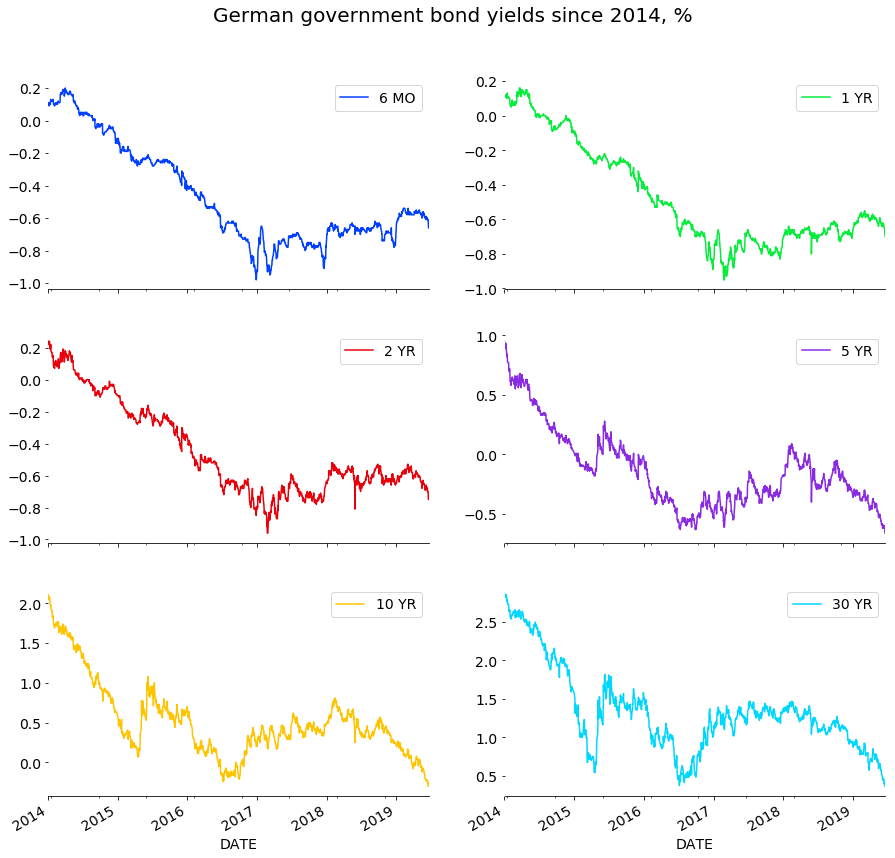

In [32]:
start = '20140101'

select_columns = ['6 MO', '1 YR', '2 YR', '5 YR','10 YR', '30 YR']
DE_bond_yields_subplot = DE_bond_yields[select_columns]

DE_bond_yields_subplot.loc[start:].plot(subplots=True, layout=(5,2), figsize=(15, 25))
sns.despine(left=True, bottom=False, right=True)
plt.suptitle("German government bond yields since 2014, %", fontsize=20, y=0.92)
plt.show();

/Users/marceldietsch/ml/env/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/marceldietsch/ml/env/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


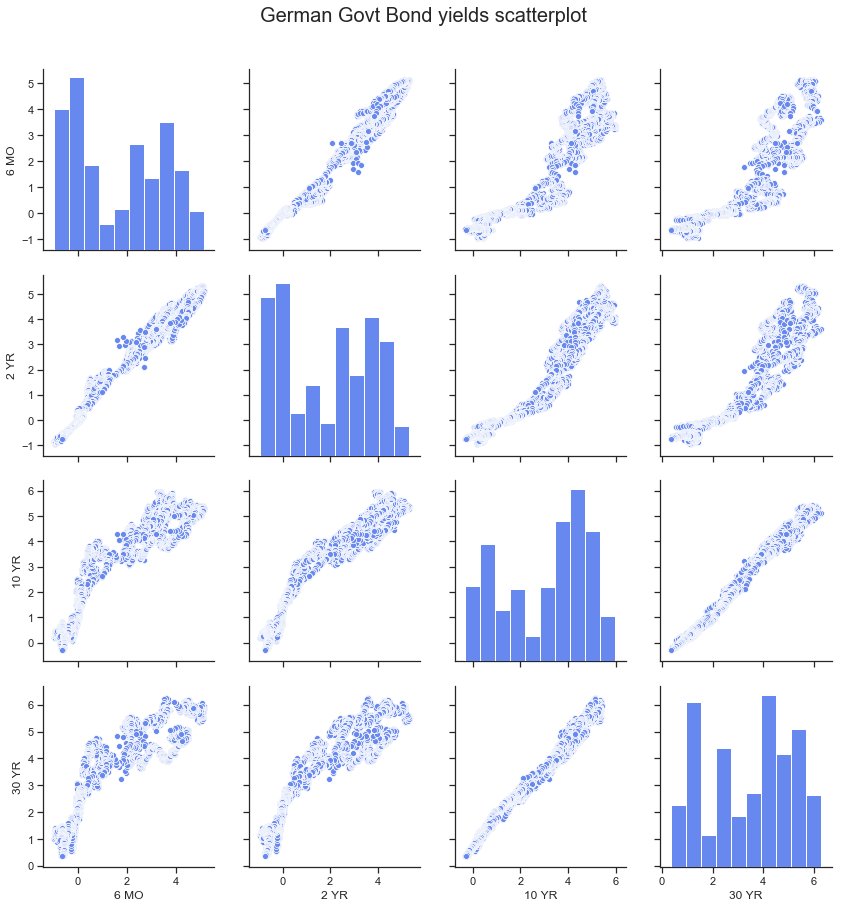

In [97]:
sns.set_palette("coolwarm")
sns.pairplot(DE_bond_yields[['6 MO', '2 YR','10 YR', '30 YR']],height=3)
plt.suptitle("German Govt Bond yields scatterplot", fontsize=20, y=1.05)
plt.show()

#### German yield curves

In [33]:
# check if correct
DE2y10y = DE_bond_yields['10 YR'] - DE_bond_yields['2 YR']

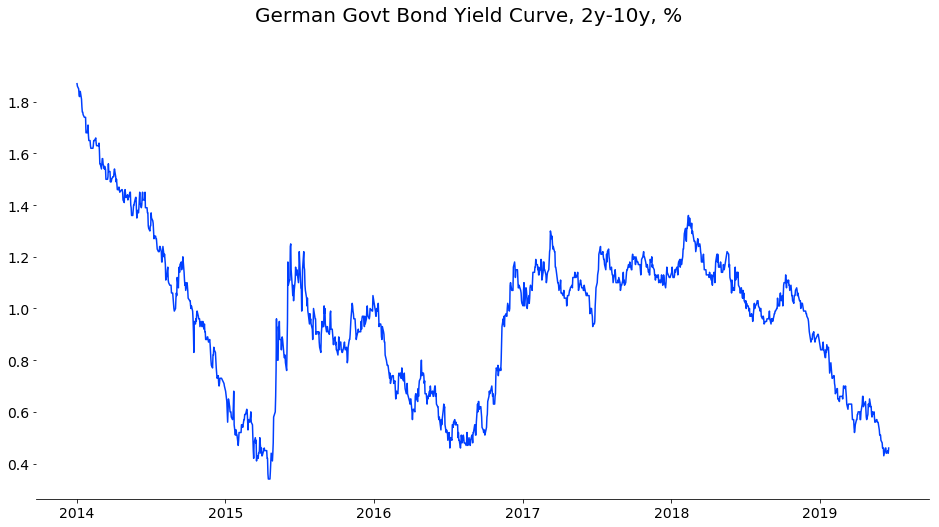

In [34]:
start = '20140101'

figure_data = DE2y10y.loc[start:]
plt.figure(figsize=(16, 8))
plt.suptitle("German Govt Bond Yield Curve, 2y-10y, %", fontsize=20)
plt.plot(figure_data)
sns.despine(left=True, bottom=False, right=True)
plt.show();

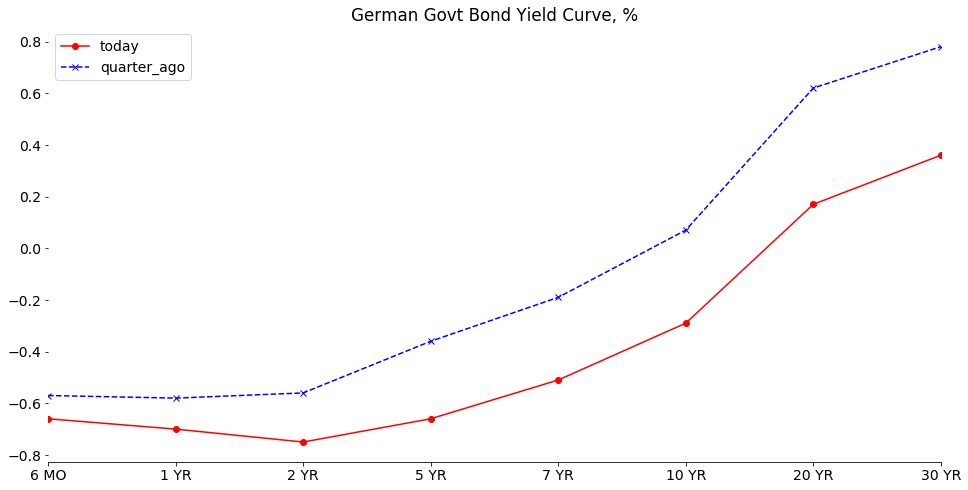

In [35]:
DE_today = DE_bond_yields.iloc[-1,:]
DE_quarter_ago = DE_bond_yields.iloc[-63,:]
df = pd.concat([DE_today, DE_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']



df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='German Govt Bond Yield Curve, %', figsize=(16, 8))
sns.despine(left=True, bottom=False, right=True)

In [36]:
# WRITE FUNCTION FOR THIS (and all other data sets)

DE_curve_today = DE_bond_yields.iloc[-1:]
DE_curve_month_ago = DE_bond_yields.iloc[-21:-20]
DE_curve_3month_ago = DE_bond_yields.iloc[-63:-62]
DE_curve_6month_ago = DE_bond_yields.iloc[-126:-125]
DE_curve_year_ago = DE_bond_yields.iloc[-252:-251]

DE_curves_combined = pd.concat([DE_curve_today, DE_curve_month_ago, DE_curve_3month_ago, DE_curve_6month_ago, DE_curve_year_ago])
DE_curves_combined

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
DATE,,,,,,,,
2019-06-19,-0.66,-0.70,-0.75,-0.66,-0.51,-0.29,0.17,0.36
2019-05-21,-0.57,-0.61,-0.65,-0.52,-0.34,-0.08,0.43,0.64
2019-03-19,-0.57,-0.58,-0.56,-0.36,-0.19,0.07,0.62,0.78
2018-12-13,-0.74,-0.67,-0.59,-0.25,-0.01,0.29,0.75,0.92
2018-06-19,-0.67,-0.69,-0.65,-0.26,0.04,0.41,1.01,1.23


#### Plot German yield curve - today v 3m ago

In [37]:
# WRITE FUNCTION FOR THIS (and all other data sets)

DE_diff_today_month_ago = DE_curves_combined.iloc[0] - DE_curves_combined.iloc[1]
DE_diff_today_3month_ago = DE_curves_combined.iloc[0] - DE_curves_combined.iloc[2]
DE_diffs_combined = pd.concat([DE_diff_today_month_ago, DE_diff_today_3month_ago], axis=1)

DE_diffs_combined = DE_diffs_combined.T
DE_diffs_combined.rename({0: "vs 1 MO", 1: "vs 3 MO"}, axis='index', inplace=True)
DE_diffs_combined

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
vs 1 MO,-0.09,-0.09,-0.10,-0.14,-0.17,-0.21,-0.26,-0.28
vs 3 MO,-0.09,-0.12,-0.19,-0.30,-0.32,-0.36,-0.45,-0.42


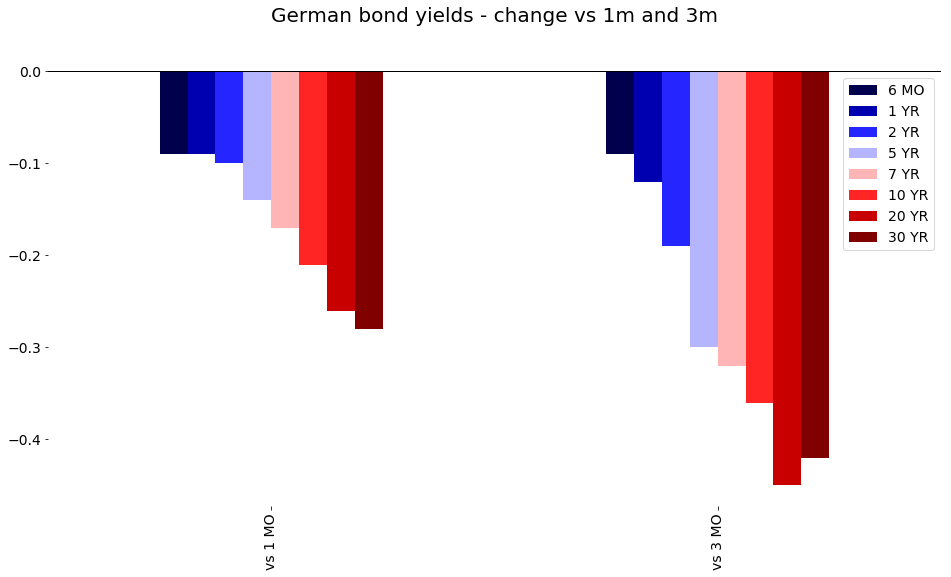

In [38]:
#DE_diffs_combined = pd.DataFrame(data=DE_diffs_combined)
DE_diffs_combined.plot.bar(figsize=(16,8), colormap='seismic')
plt.title("German bond yields - change vs 1m and 3m", fontsize=20, y=1.1)
plt.axhline(0, color = 'k', linestyle = '-', linewidth = 1)
sns.despine(top=True, left=True, right=True, bottom=True)

plt.show()

## Australian yields

In [39]:
URL_OZ = "https://www.rba.gov.au/statistics/tables/xls/f02d.xls"

try:
    OZ_download = pd.read_excel(URL_OZ2, parse_dates=True)
    OZ_download.to_excel("data/OZ.xls")
except Exception as e:
    print("Problem with download via Pandas read_excel from RBA website")
    print(e)
    print("============================================================")
    print("Trying with wget downloader instead")
    print("============================================================")
    !wget {URL_OZ} -O "data/OZ.xls" -q

file = Path() / 'data/OZ.xls'  
size = file.stat().st_size

if size == 0:
    OZ_yields = pd.read_excel("data/OZ_backup.xls", parse_dates=True)
else:
    OZ_yields = pd.read_excel("data/OZ.xls", parse_dates=True)
    shutil.copy("data/OZ.xls", "data/OZ_backup.xls")

Problem with download via Pandas read_excel from RBA website
name 'URL_OZ2' is not defined
Trying with wget downloader instead


In [40]:
OZ_yields = OZ_yields[10:]

In [41]:
OZ_yields.rename(columns={OZ_yields.columns[0]: "DATE"}, inplace=True)
OZ_yields.set_index(['DATE'], drop=True, inplace=True)

In [42]:
OZ_yields_cl = OZ_yields.rename(columns={OZ_yields.columns[0]: "2 YR", \
                 OZ_yields.columns[1]: "3 YR", OZ_yields.columns[2]: "5 YR", \
                 OZ_yields.columns[3]: "10 YR"})

In [43]:
# remove unneeded columns 
OZ_yields = OZ_yields_cl.drop(OZ_yields.columns[[4, 5, 6, 7]], axis=1)

In [44]:
OZ_yields.tail()

,2 YR,3 YR,5 YR,10 YR
DATE,,,,
2019-06-13,1.005,0.99,1.065,1.4
2019-06-14,1,0.98,1.05,1.375
2019-06-17,1.03,1.015,1.085,1.39
2019-06-18,1.01,1,1.06,1.37
2019-06-19,0.98,0.965,1.03,1.34


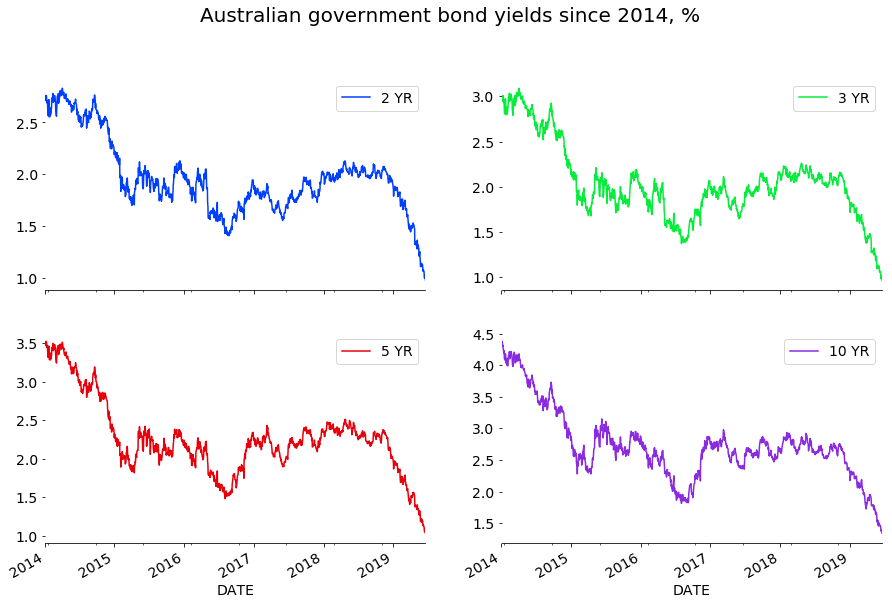

In [45]:
start = '20140101'

OZ_yields.loc[start:].plot(subplots=True, layout=(5,2), figsize=(15, 25))
sns.despine(left=True, bottom=False, right=True)
plt.suptitle("Australian government bond yields since 2014, %", fontsize=20, y=0.92)
plt.show();

#### Plot Australian yield curve - today v 3m ago

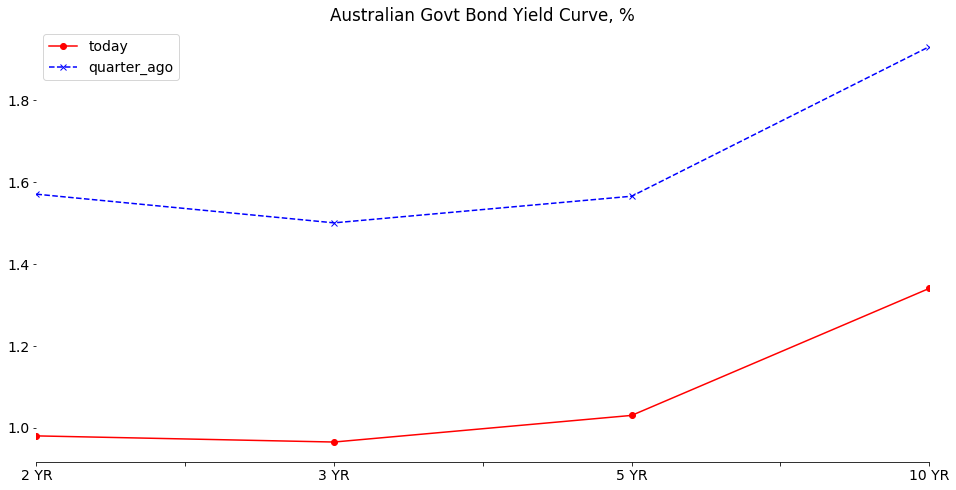

In [46]:
OZ_today = OZ_yields.iloc[-1,:]
OZ_quarter_ago = OZ_yields.iloc[-63,:]
df = pd.concat([OZ_today, OZ_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']

df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='Australian Govt Bond Yield Curve, %', figsize=(16, 8));

sns.despine(left=True, bottom=False, right=True)

## Russian yields

In [47]:
#https://www.cbr.ru/eng/hd_base/zcyc_params/

import bs4 as bs  
import pickle  
import requests

In [48]:
resp = requests.get('https://www.cbr.ru/eng/hd_base/zcyc_params/')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table')

## Canada

In [49]:
# "https://www.bankofcanada.ca/valet/observations/FXCADUSD/csv"

## Japan

In [50]:
# load long-term history and most recent data points 
japan_hist = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/historical/jgbcme_all.csv",\
                         header=1, parse_dates=['Date'])
japan_current = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/jgbcme.csv", \
                            header=1, parse_dates=['Date'])

In [51]:
# now likely not needed that parse_dates=['column'] works
# convert date format from separator "/" to "-"
#japan_hist["Date"] = pd.to_datetime(japan_hist["Date"]).dt.strftime('%Y-%m-%d')
#japan_current["Date"] = pd.to_datetime(japan_current["Date"]).dt.strftime('%Y-%m-%d')

In [52]:
# convert those columns in japan_hist that are objects to floats
for col in japan_hist.columns[1:]:
    japan_hist[col] = pd.to_numeric(japan_hist[col], errors='coerce')

In [53]:
# replace index column with date column
japan_hist.set_index(['Date'], drop=True, inplace=True)
japan_current.set_index(['Date'], drop=True, inplace=True)

In [54]:
combined_JGB = pd.concat([japan_hist, japan_current])

In [55]:
# save a copy locally as a CSV
combined_JGB.to_csv("data/JGB_yields.csv")

In [56]:
# check data type of index - it should be datetime
# however parse_dates did not work above in read_csv, so it still is an object
combined_JGB.index

DatetimeIndex(['1974-09-24', '1974-09-25', '1974-09-26', '1974-09-27',
               '1974-09-28', '1974-09-30', '1974-10-01', '1974-10-02',
               '1974-10-03', '1974-10-04',
               ...
               '2019-06-06', '2019-06-07', '2019-06-10', '2019-06-11',
               '2019-06-12', '2019-06-13', '2019-06-14', '2019-06-17',
               '2019-06-18', '2019-06-19'],
              dtype='datetime64[ns]', name='Date', length=11532, freq=None)

In [57]:
# now likely not needed that parse_dates=['column'] works
# convert index to datetime
#combined_JGB.index = pd.to_datetime(combined_JGB.index)

In [58]:
combined_JGB.shape

(11532, 15)

In [59]:
combined_JGB.tail(10)

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
Date,,,,,,,,,,,,,,,
2019-06-06,-0.183,-0.207,-0.227,-0.240,-0.240,-0.238,-0.232,-0.209,-0.163,-0.116,0.091,0.268,0.345,0.412,0.456
2019-06-07,-0.173,-0.197,-0.221,-0.235,-0.229,-0.231,-0.222,-0.202,-0.157,-0.112,0.097,0.268,0.345,0.403,0.444
2019-06-10,-0.176,-0.199,-0.225,-0.238,-0.234,-0.239,-0.232,-0.207,-0.163,-0.117,0.087,0.243,0.314,0.360,0.395
2019-06-11,-0.176,-0.194,-0.212,-0.226,-0.221,-0.228,-0.226,-0.201,-0.152,-0.107,0.097,0.253,0.323,0.358,0.394
2019-06-12,-0.177,-0.195,-0.213,-0.224,-0.226,-0.228,-0.226,-0.202,-0.152,-0.107,0.092,0.252,0.313,0.348,0.385
2019-06-13,-0.178,-0.200,-0.216,-0.229,-0.231,-0.228,-0.222,-0.202,-0.152,-0.108,0.095,0.263,0.328,0.370,0.405
2019-06-14,-0.178,-0.206,-0.220,-0.234,-0.235,-0.233,-0.232,-0.212,-0.167,-0.122,0.081,0.248,0.318,0.371,0.412
2019-06-17,-0.175,-0.196,-0.214,-0.230,-0.229,-0.228,-0.227,-0.207,-0.164,-0.122,0.082,0.244,0.319,0.371,0.413
2019-06-18,-0.181,-0.203,-0.221,-0.233,-0.230,-0.233,-0.231,-0.212,-0.167,-0.122,0.077,0.238,0.307,0.362,0.404


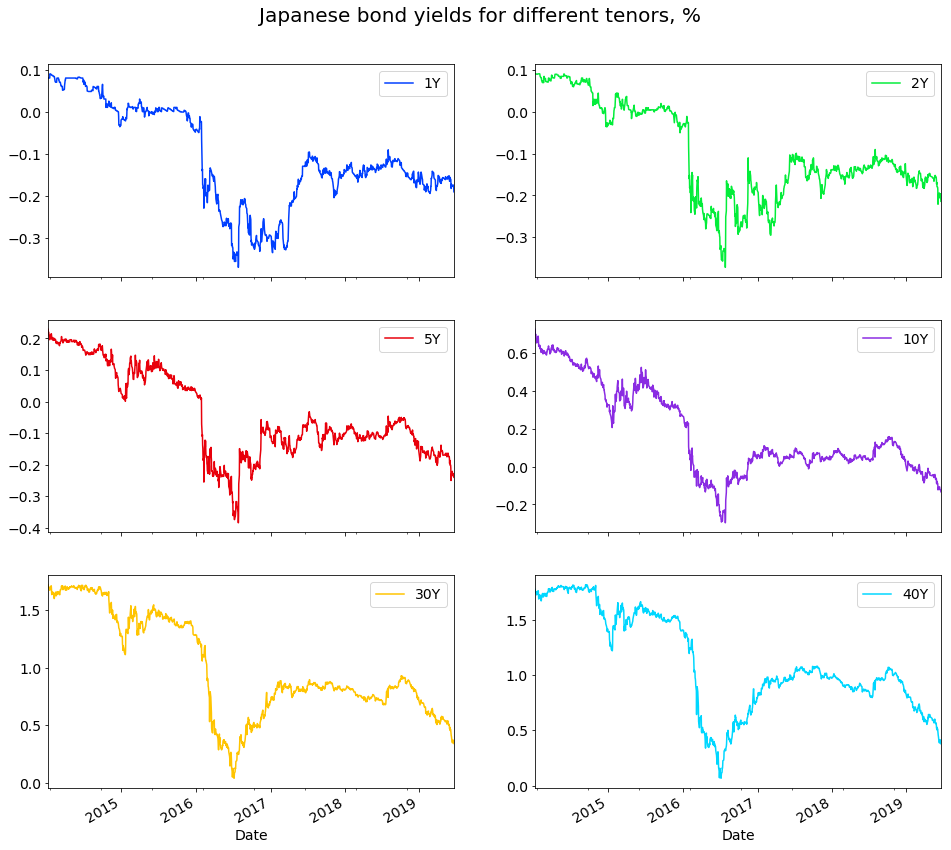

In [60]:

select_columns = ['1Y', '2Y', '5Y','10Y', '30Y', '40Y']
combined_JGB_subplot = combined_JGB[select_columns]

start = '20140101'
end = today
combined_JGB_subplot.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 20))
plt.suptitle("Japanese bond yields for different tenors, %", fontsize=20, y=0.92)
plt.show()


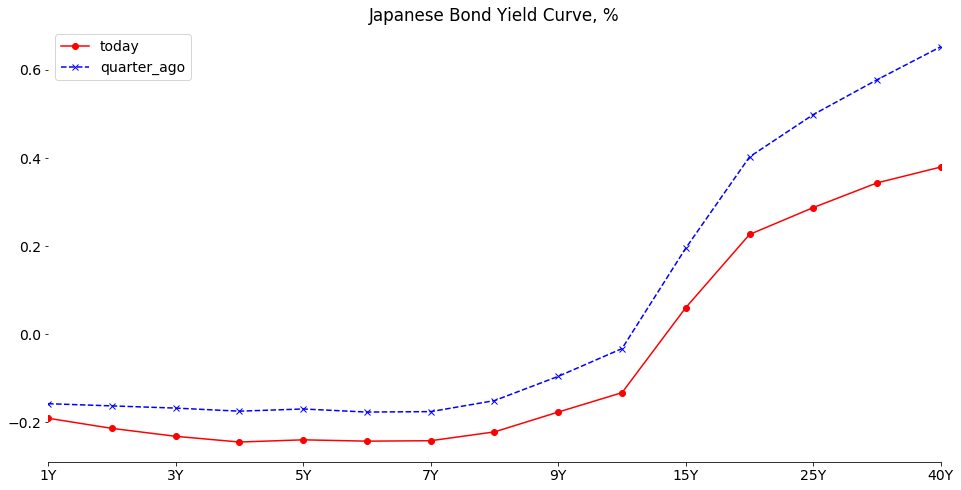

In [61]:
JGB_today = combined_JGB.iloc[-1,:]
JGB_quarter_ago = combined_JGB.iloc[-63,:]
df = pd.concat([JGB_today, JGB_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']

df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='Japanese Bond Yield Curve, %', figsize=(16, 8));

sns.despine(left=True, bottom=False, right=True)

#### Todo

In [62]:
# Write function for DE yield curves

#def generate_yieldcurves:

#DE_yield_curve = pd.DataFrame()
#DE_yield_curve['2y10y'] =  DE_bond_yields.apply(lambda x: x['10y'] - x['2y'], axis=1)

#def clean_and_join(input_name, tenor):
#    """
#    """
#    combined = pd.DataFrame() 
#    for i in range(len(tenor)):
#        result = bunds_clean(DE[input_name[i]], tenor[i])
#        combined = pd.concat([combined, result], axis=1)
#    return combined